In [129]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV


In [130]:
game_data=pd.read_csv("vidgames_cleaned.csv")
game_data = game_data.drop(columns = 'Unnamed: 0')
game_data.head()

,Name,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,007: Quantum of Solace,2008.0,Action,Activision,1.82,64.563380,71.0,6.653906,128.0,Treyarch,T
1,18 Wheeler: American Pro Trucker,2002.0,Racing,Acclaim Entertainment,0.11,52.000000,17.0,6.800000,8.0,Acclaim Studios Cheltenham,E
2,187: Ride or Die,2005.0,Racing,Ubisoft,0.06,51.000000,40.0,6.900000,8.0,Ubisoft Paris,M
3,2002 FIFA World Cup,2002.0,Sports,Electronic Arts,0.24,78.653846,26.0,8.220000,10.0,EA Sports,E
4,2010 FIFA World Cup South Africa,2010.0,Sports,Electronic Arts,1.73,78.593407,91.0,7.821795,78.0,Electronic Arts,E


# Regression Models
----------

## **1) Multivariate Linear Regression**

First, we would like to predict Global Sales using a Multivariate Linear Regression model.

To start with, we will associate the categorical variables 'Genre', 'Rating', 'Publisher' and 'Developer' to a specific dummy numerical value, which is a form of one-hot encoding that will allow us to use regression techniques on categorical variables. Then, to avoid multicolinearity, we remove the first column of each variable, thus avoiding the dummy trap. 

In [131]:
genre_int = pd.get_dummies(game_data["Genre"], drop_first=True)
rating_int = pd.get_dummies(game_data["Rating"], drop_first=True)
publisher_int = pd.get_dummies(game_data["Publisher"], drop_first=True)
dev_int=pd.get_dummies(game_data["Developer"], drop_first=True)

In [132]:
#setting up the predictor and response data
X=game_data[["Critic_Score", "Year_of_Release", "User_Score", "Critic_Count", "User_Count"]].copy()
X=pd.concat([X, genre_int, rating_int, dev_int, publisher_int], axis=1)
#remove duplicate values spawned by identical values of the developer variable and publisher variable, where select games are both developed and published by the same company
X = X.loc[:,~X.columns.duplicated()].copy()
y=game_data['Global_Sales']
#splitting the data set into train and test in 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [133]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Goodness of Fit for Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))

print()

# Accuracy for Test Data
y_test_pred = linreg.predict(X_test)
print("Accuracy of Model        \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))

print()


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.42914294366303574

Accuracy of Model        	Test Dataset
Explained Variance (R^2) 	: 0.31369302632386264



Next, we will plot our actual vs predicted values. First up is the train dataset.

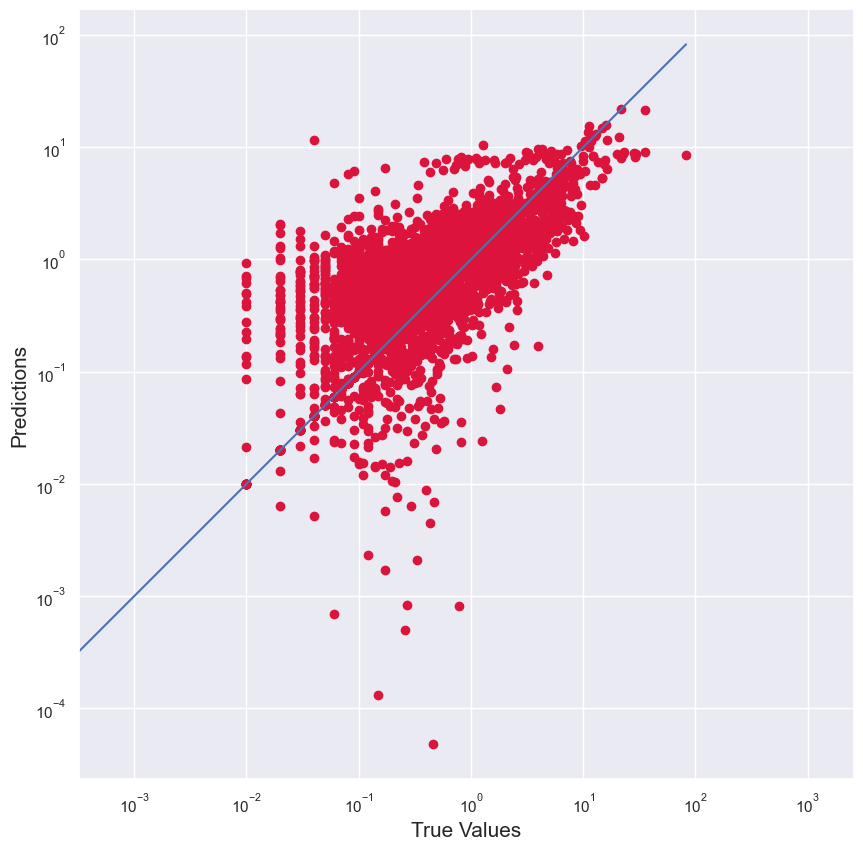

In [134]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Next, we will plot the test dataset.

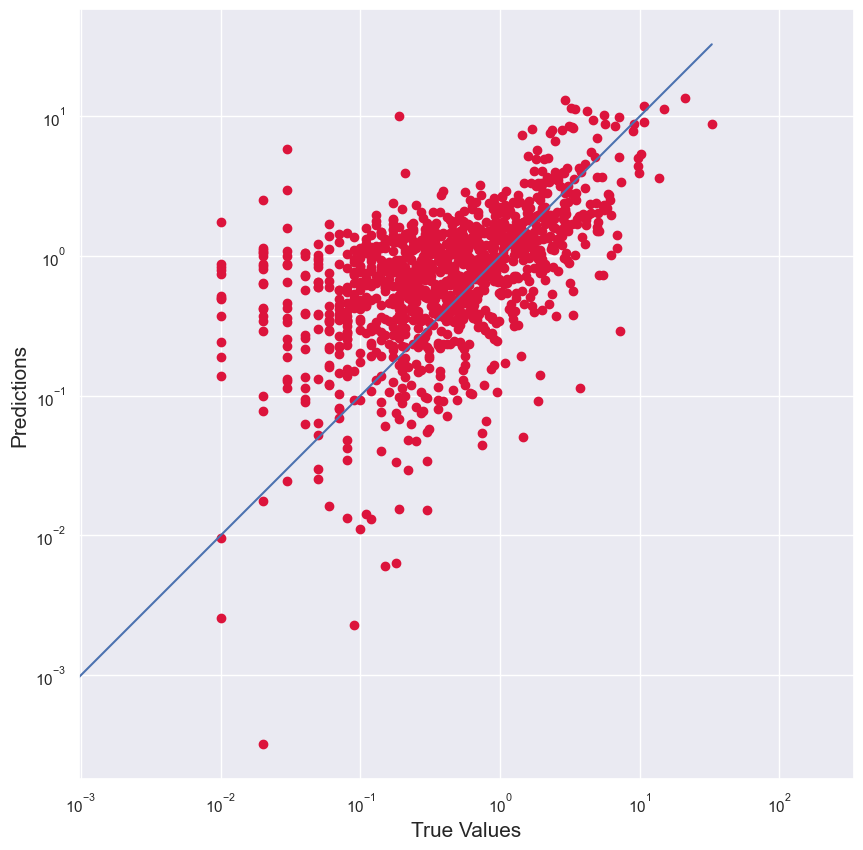

In [135]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

As shown by both the graphs, as well as the $R^{2}$ values, train dataset is performing slightly better than test dataset. However, the $R^{2}$ value of the test dataset is worryingly low at approximately 0.31, so we will take a look at a Random Forest Regression model to see if we can improve the accuracy.

## **2) Random Forest Regression**

In [136]:
#setting up the random forest model
forest=RandomForestRegressor(n_estimators=5, max_samples=3000, random_state=1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_samples=3000, n_estimators=5, random_state=1)

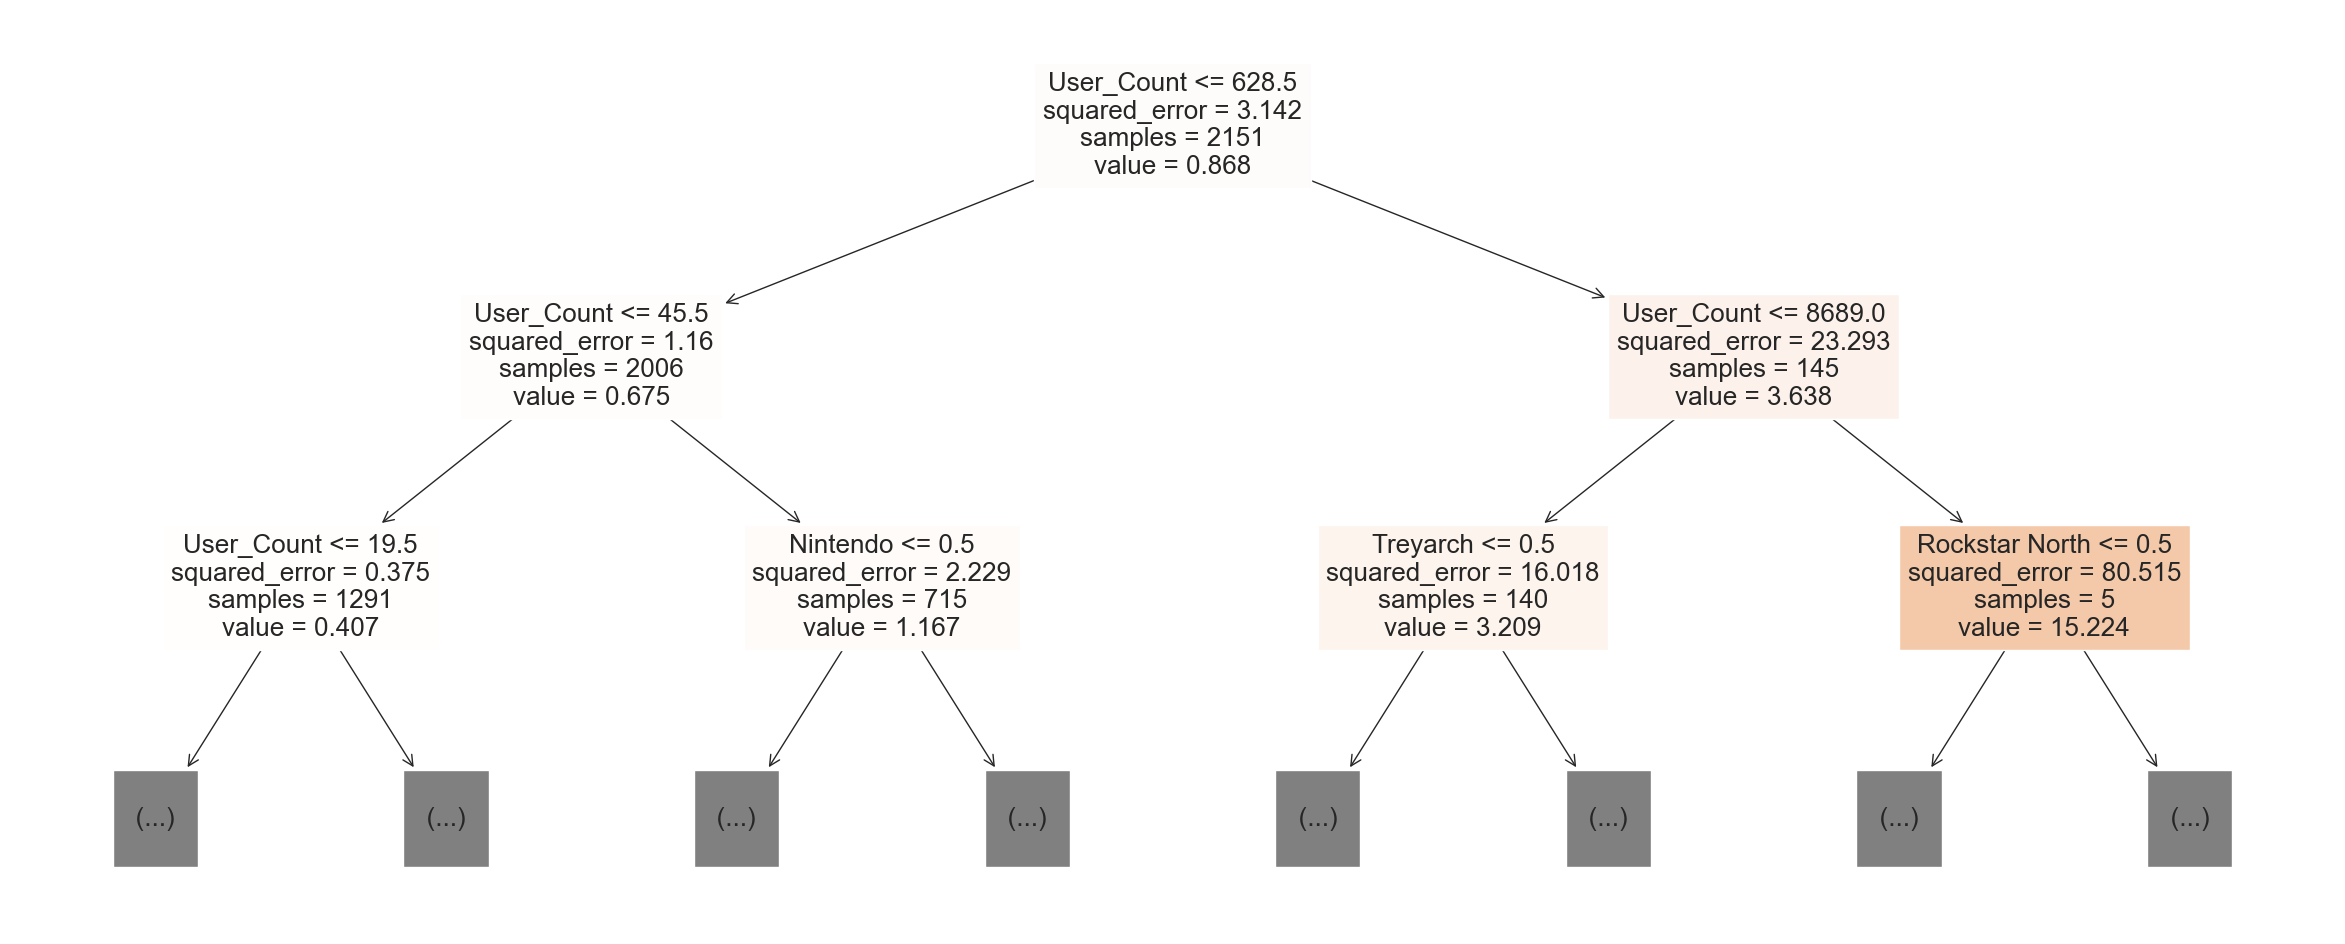

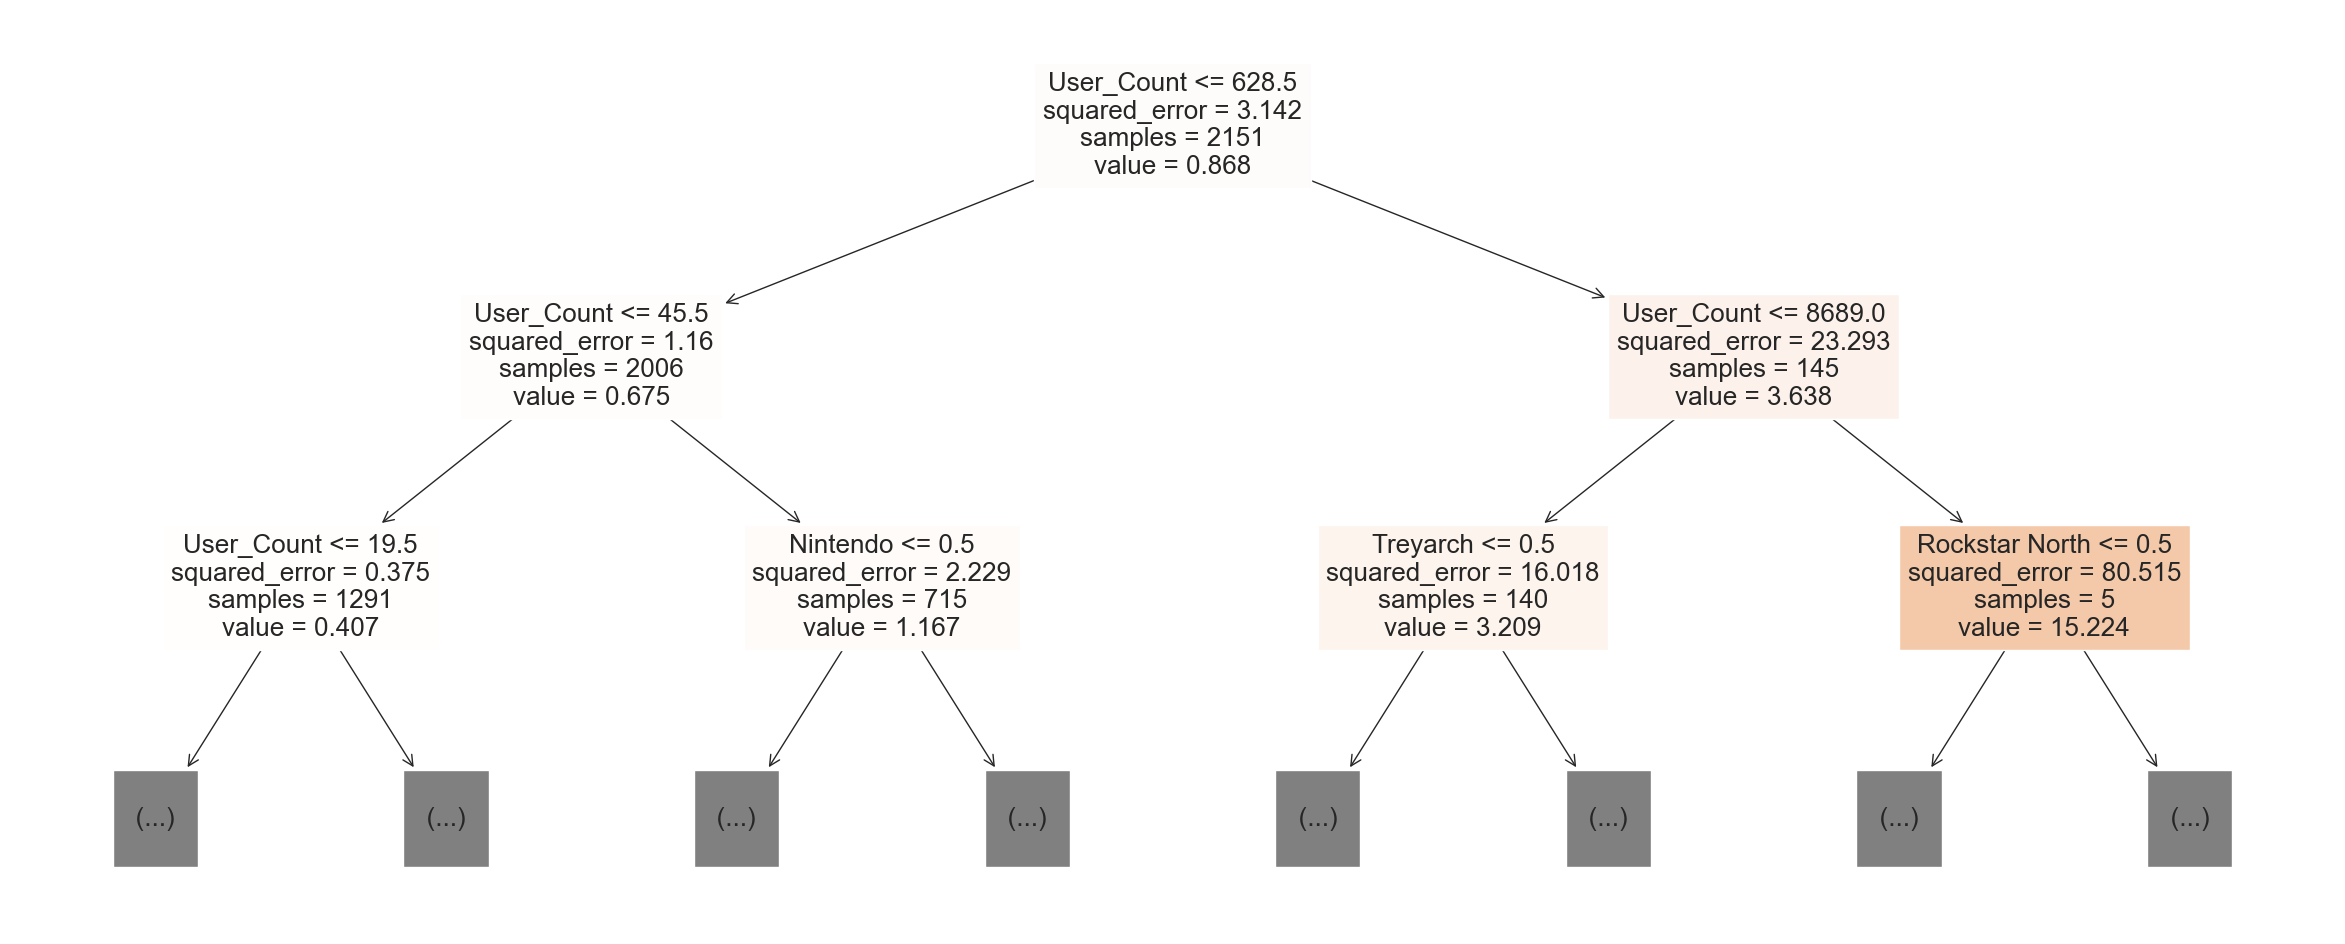

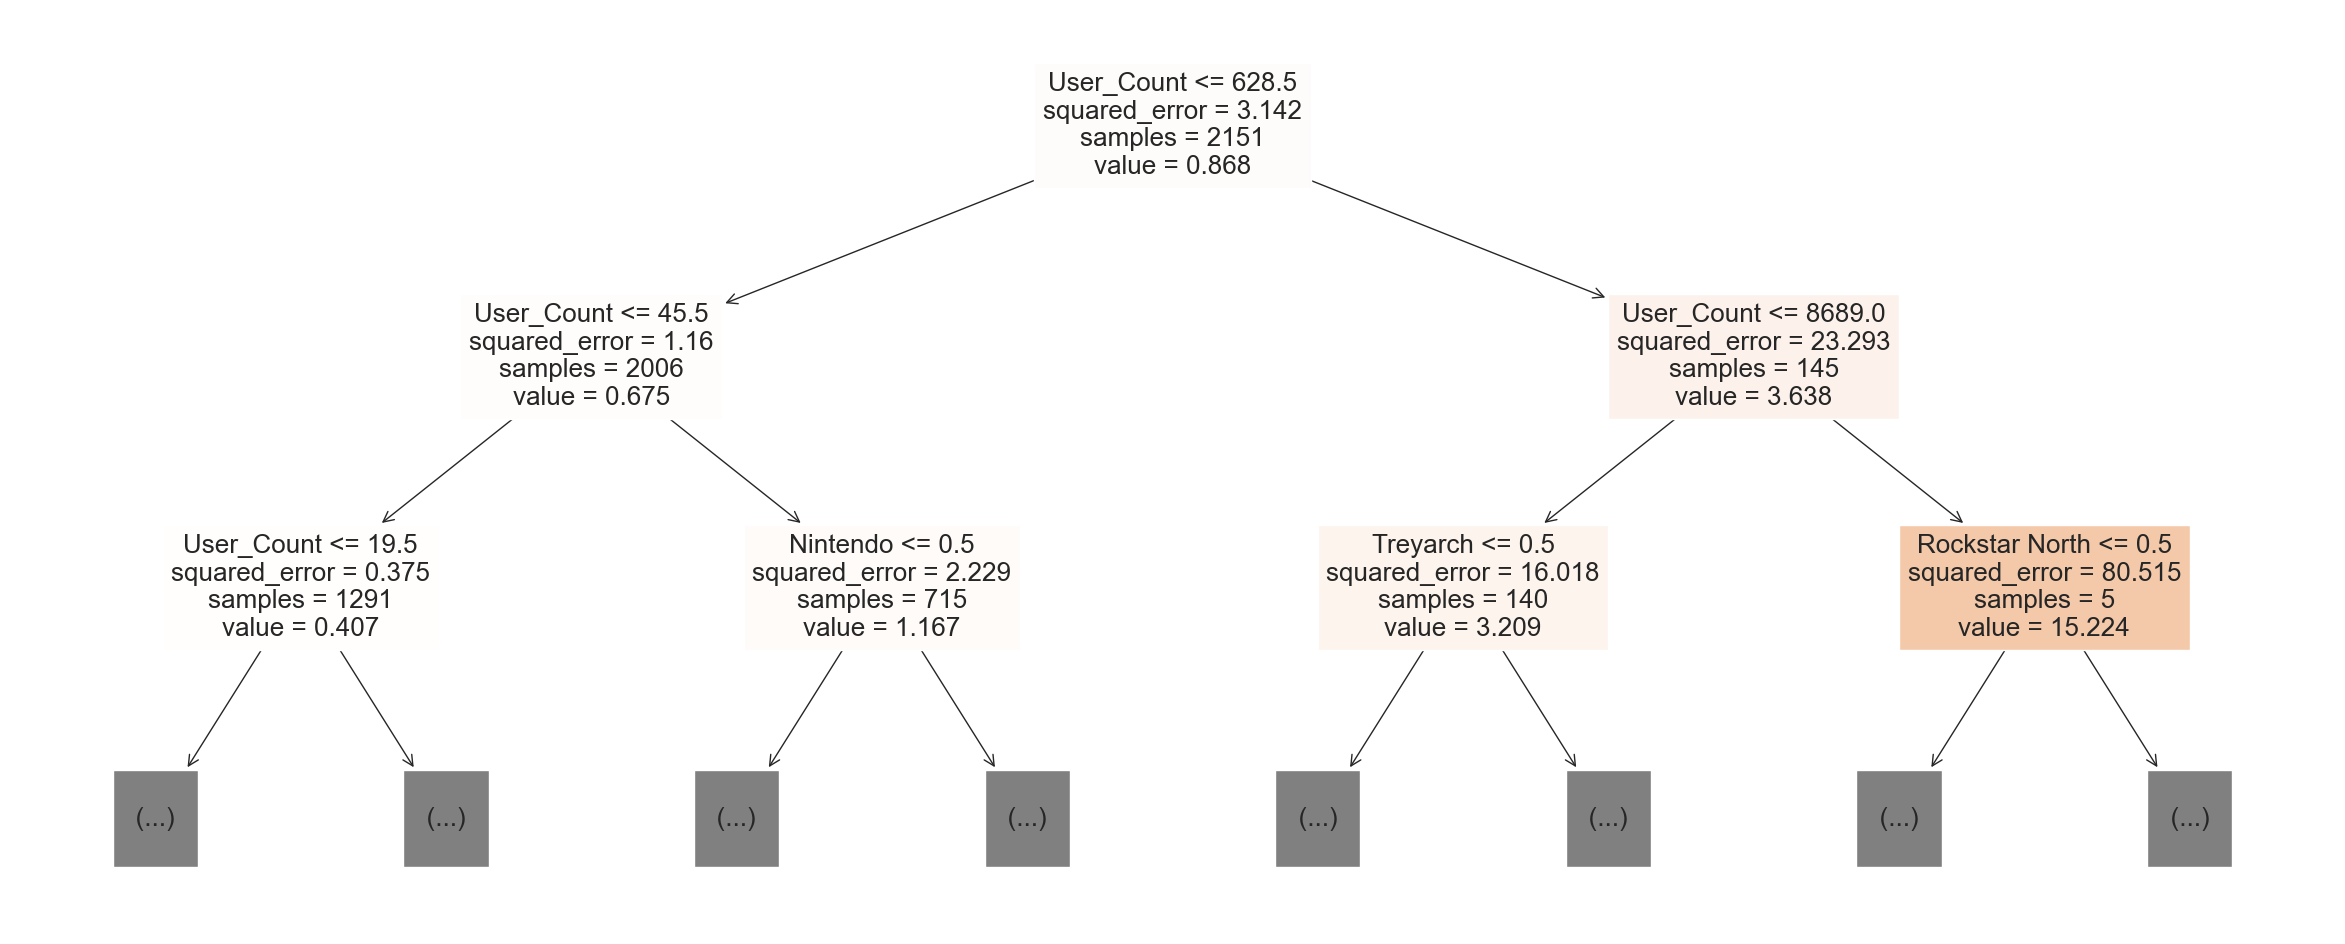

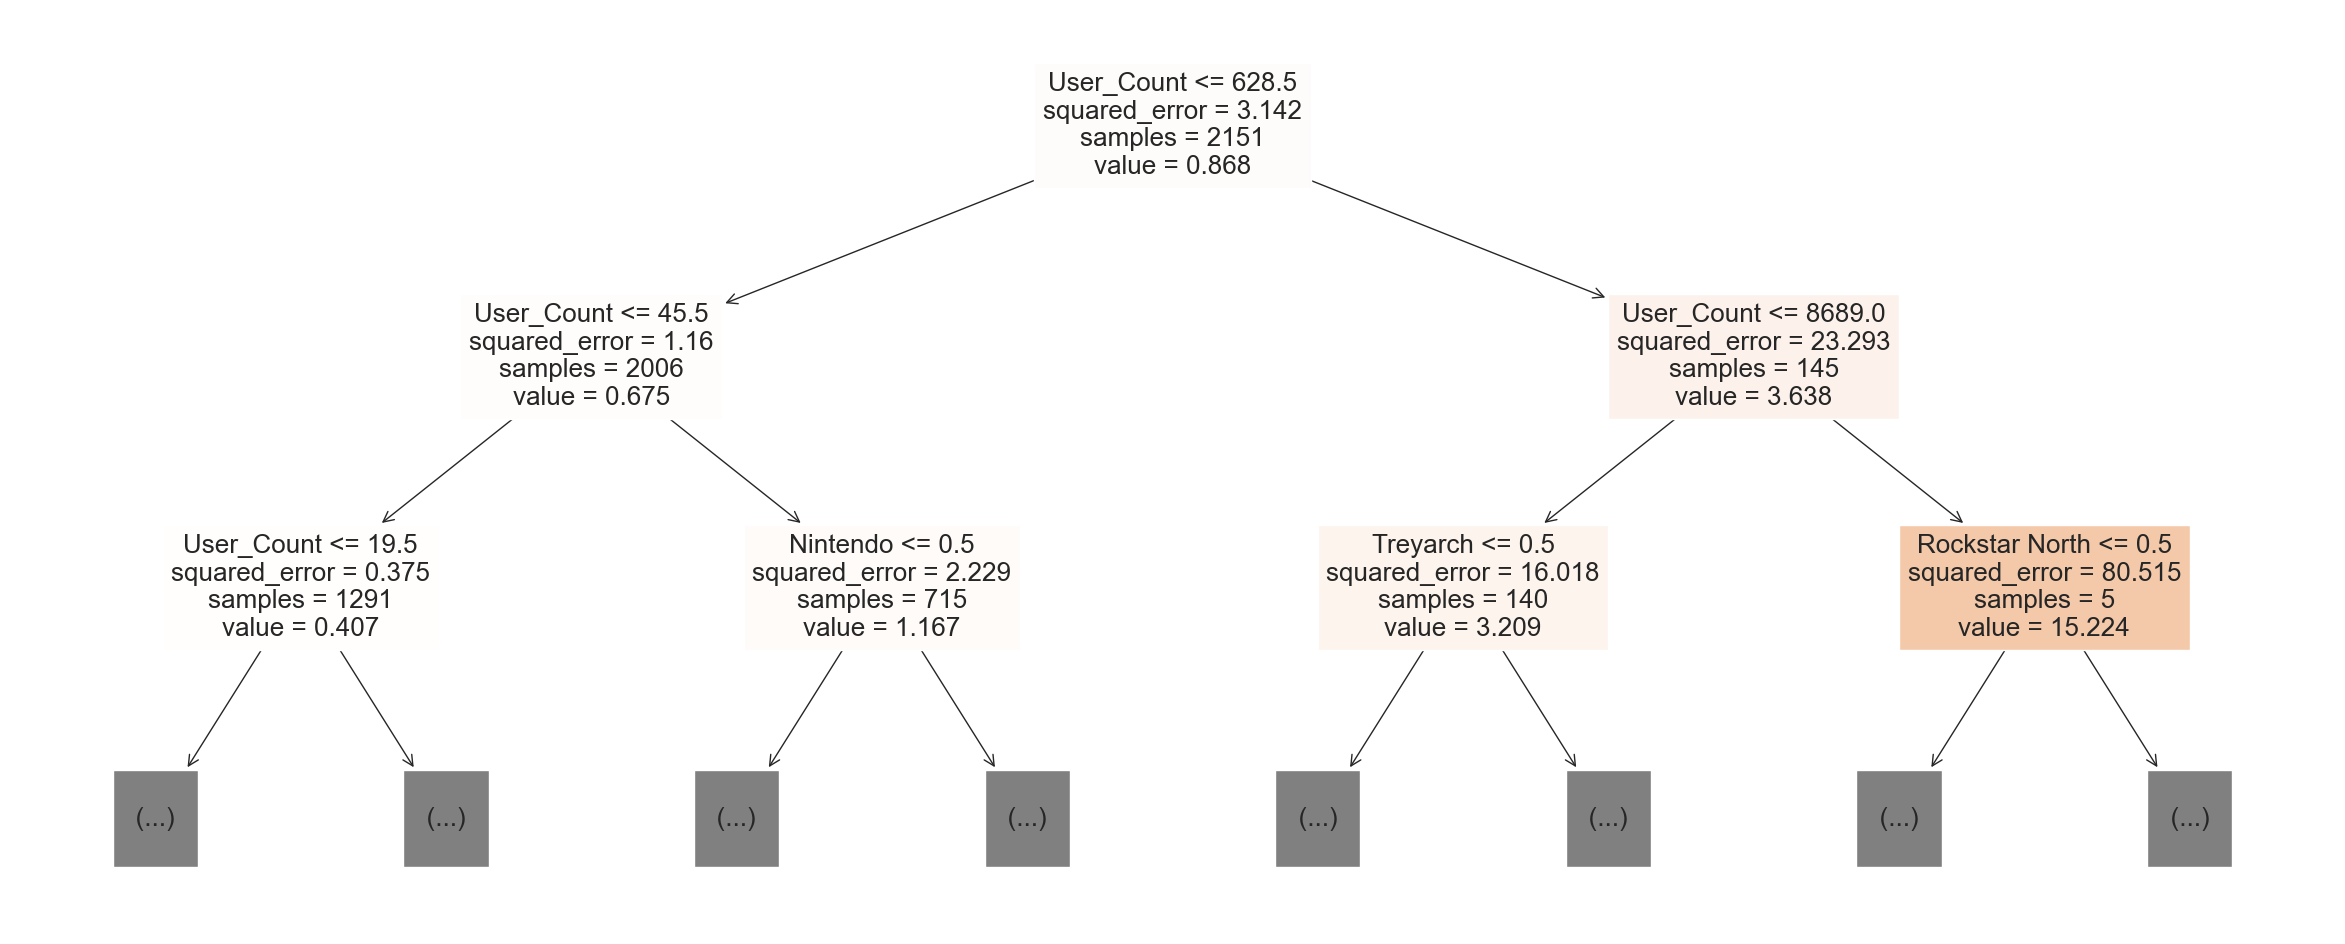

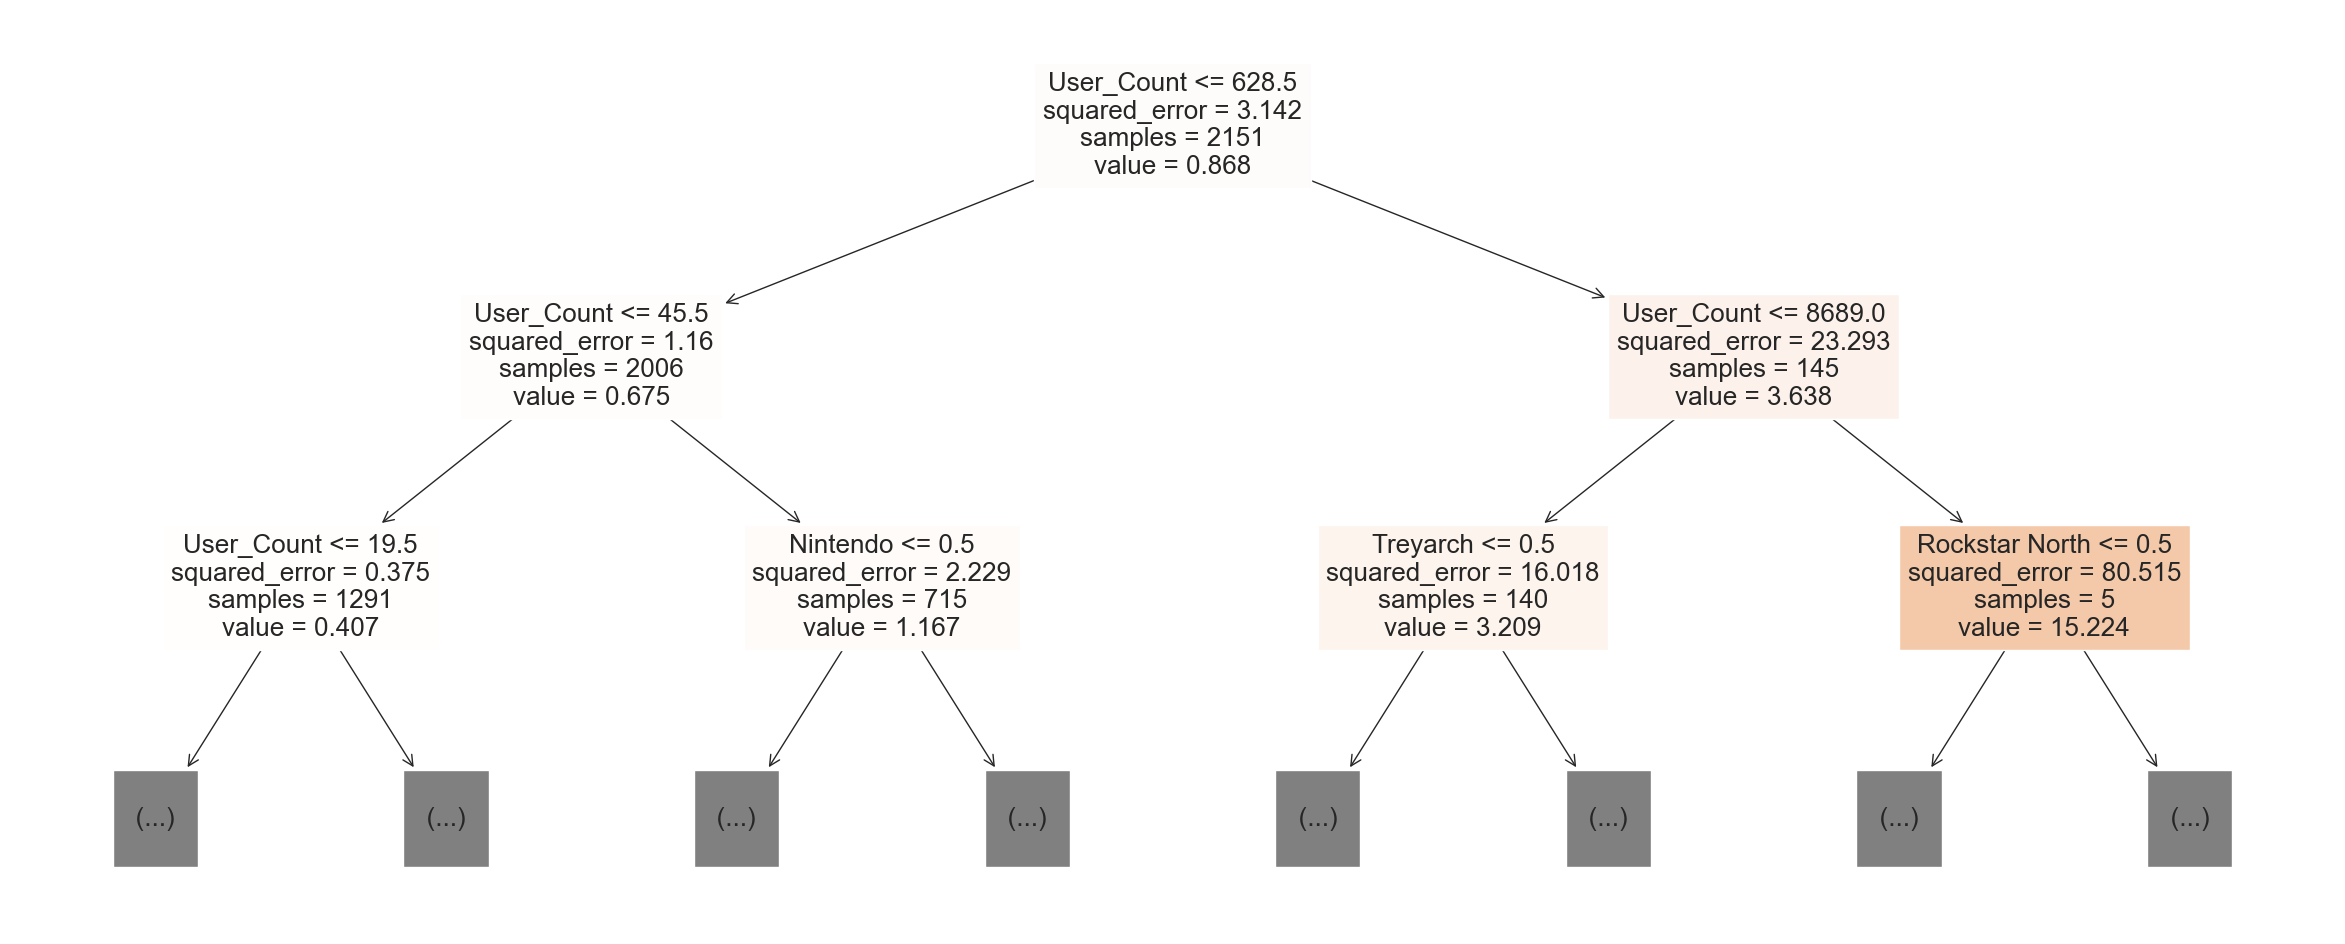

In [137]:
for tree_in_forest in forest.estimators_:
    fig, ax = plt.subplots(figsize=(30, 12))
    tree.plot_tree(forest.estimators_[0], feature_names=list(X), filled=True, max_depth=2)
    plt.show()

As illustrated in a snippet of the Random Forest model above, User Count is shown to be the most important variable when it comes to predicting Global Sales. 
We can also observe the importances of every feature using the *feature_importances_* command.

In [138]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
importances = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(importances)

User_Count            0.327685
Critic_Score          0.118902
Critic_Count          0.098971
Nintendo              0.070889
User_Score            0.058009
                        ...   
Next Entertainment    0.000000
Nfusion               0.000000
Nicalis               0.000000
Nightlight Studios    0.000000
Mistwalker, Artoon    0.000000
Length: 1427, dtype: float64


Thus, we have successfully found the answer to our second problem statement, that is, which feature is the most important in predicting Global Sales. As shown above, **User Count**, that is, the number of users that leave reviews for the game is the most important feature, followed by **Critic Score** and **Critic Count**.

Next, we will measure the accuracy of the model.

In [139]:
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", forest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", forest.score(X_test, y_test))
print()


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7194043606275604

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.32093771453005626



Then we will plot the actual vs predicted values of the train dataset...

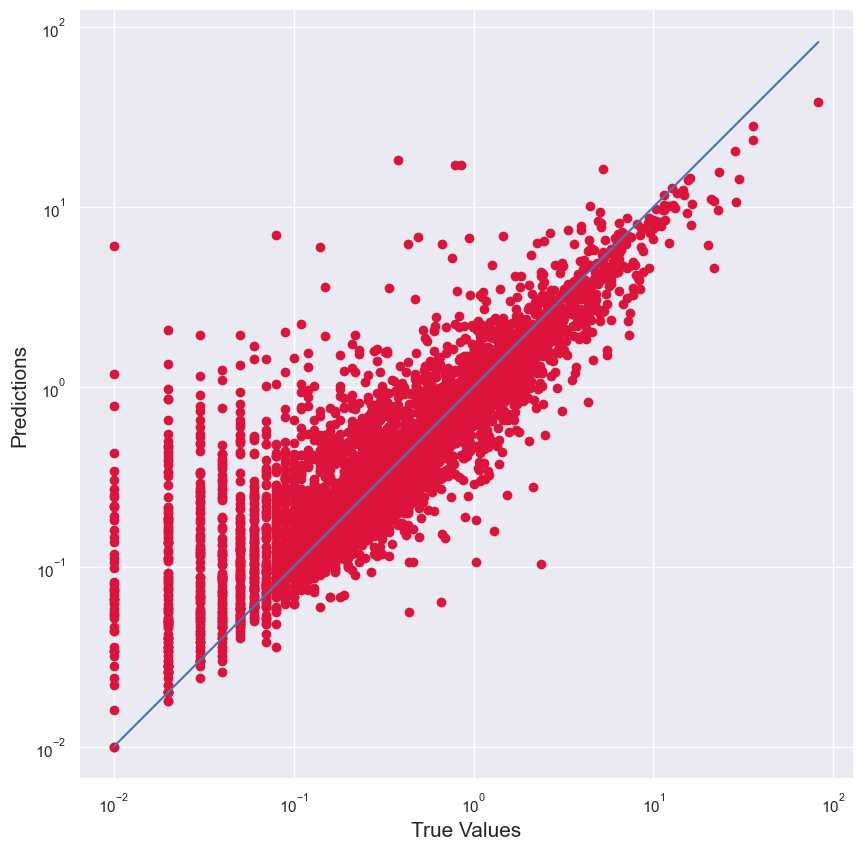

In [140]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

....and the test dataset.

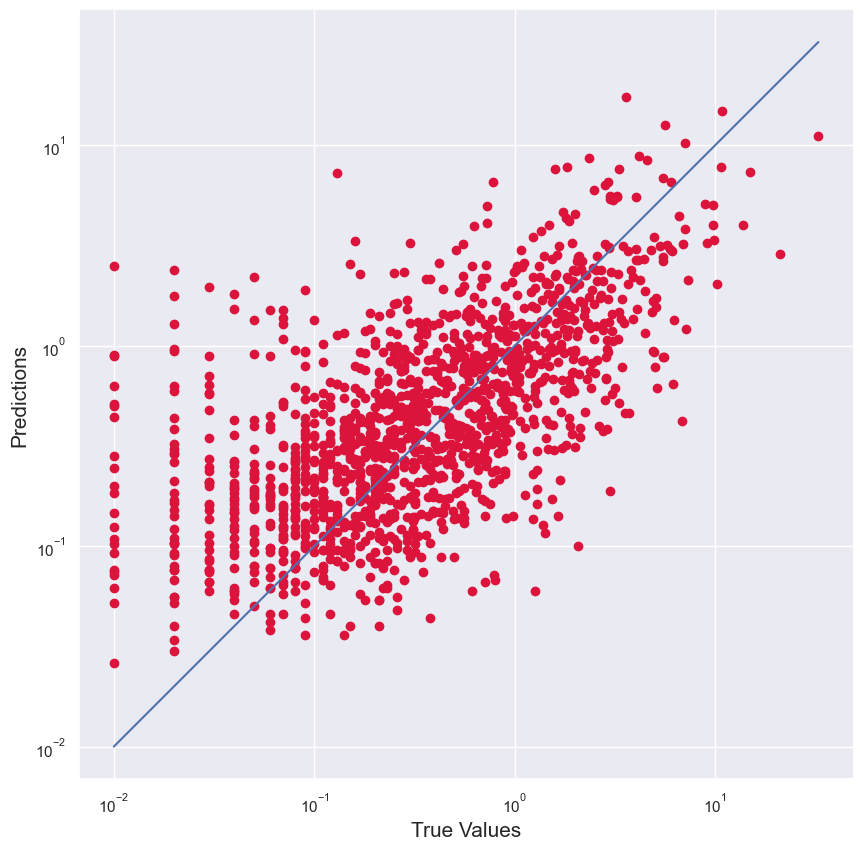

In [141]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Using Random Forest Regression, we can observe that the train data is performing at a far higher accuracy compared to Multivariate Linear Regression (~0.72 vs ~0.43). The test data however, has a similar accuracy to Multivariate Linear Regression.

We can observe that the test data is performing much worse than the train data. This is because overfitting has occurred. Overfitting commonly occurs when there is a huge number of variables in the dataset. Though we managed to reduce the number of features through cleaning, the use of one-hot encoding for dummy variables caused the splitting of the categorical variables like Publishers into their own individual variable, thus causing overfitting. There are a total of 1427 variables used to predict Global Sales, which gives us an idea of how many variables there are.

## **Conclusion for Random Forest Regression**

Random Forest Regression has a test value $R^{2}$ of 0.32, slightly higher than Linear Regression, but there is no significant jump in accuracy.
However, overfitting has occurred, and we will now attempt to overcome it using Ridge Regression.

## **3) Ridge Regression**

Next, we will use Ridge Regression to test the dataset, as Ridge Regression is designed to help overcome overfitting.

Before we proceed, we will first define a function *get_cv_r2*, to determine the 5-fold-cross validation score of the dataset in order to determine whether overfitting occurs.

In [142]:
def get_cv_r2(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f'R2 mean: {np.mean(scores)}')

In [143]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

# get cross val scores
get_cv_r2(ridge, X_train, y_train)

# determine best alpha
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge,
                    param_grid=param_grid,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best r2:\t ', grid_result.best_score_)
print('Best alpha:\t ', grid_result.best_params_['alpha'])

R2 mean: 0.3444875808667893
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best r2:	  0.3444875808667901
Best alpha:	  1


Next, we will measure the accuracy of the model.

In [152]:
optimal_ridge = Ridge(alpha=grid_result.best_params_['alpha'])
optimal_ridge.fit(X_train, y_train)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", optimal_ridge.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", optimal_ridge.score(X_test, y_test))
print()


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.4146890166663453

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.3660716009587123



Once again, plotting actual vs predicted values for train data....

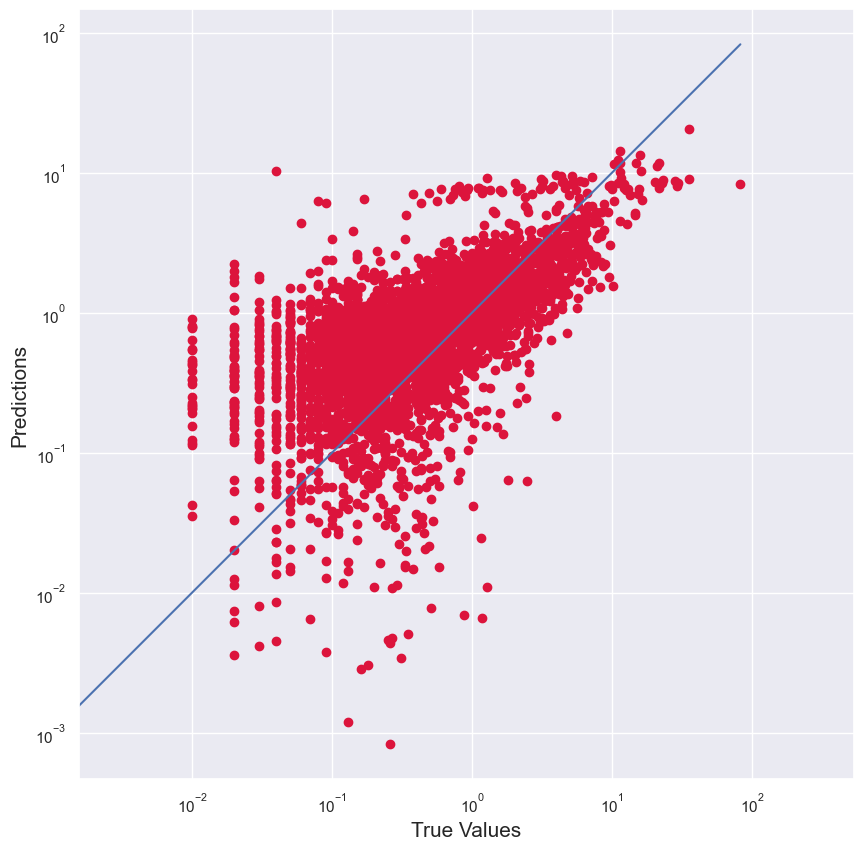

In [145]:
y_train_pred = optimal_ridge.predict(X_train)
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

....and test data.

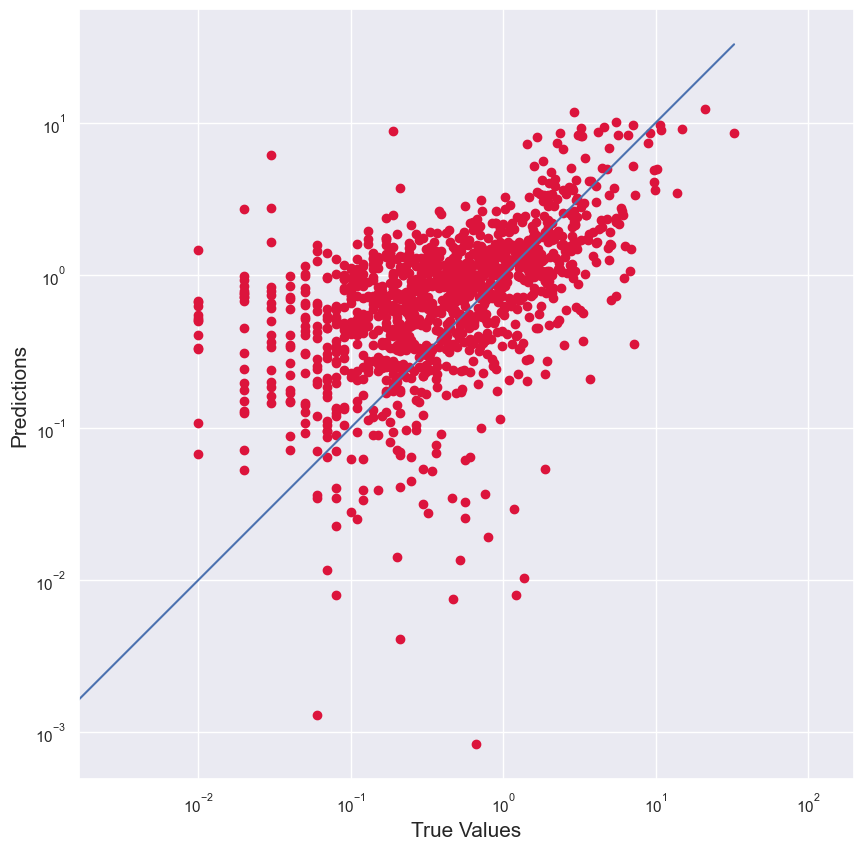

In [146]:
y_test_pred = optimal_ridge.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

As we can observe, the $R^{2}$ of the train dataset have been significantly lowered, from ~0.76 to ~0.41, but there has been a slight increase in $R^{2}$ for the test dataset, from ~0.32 to ~0.37.
However, both the train and test data performed similiarly well, and there does not exist a huge difference in accuracy that indicates overfitting. 
Therefore, we can conclude that Ridge Regression has successfully solved the problem of overfitting.

## **Conclusion for Ridge Regression**

Test data accuracy performed higher than both Multivariate Linear Regression and Random Forest Regression, at 0.37, and it also solves the problem of overfitting, making it the best model of the three we have used so far.
However, an $R^{2}$ value of 0.37 is truly too low to be used in predicting Global Sales, therefore, we would like to take a look at one of the more popular regression methods: Extreme Gradient Boost (XGBoost) and see if we can improve our test accuracy.

## **4) XG Boost**

In [154]:
import sys
!{sys.executable} -m pip install xgboost

In [148]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [149]:
game_xgb = xgb.XGBRegressor(objective ='reg:squarederror',tree_method="hist", 
                             eval_metric=mean_squared_error, n_estimators = 20, 
                             seed = 999, max_leaves = 0)
game_xgb.fit(X_train,y_train.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001E9E66F3DC0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=0, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [158]:
y_test_pred = game_xgb.predict(X_test)
y_train_pred = game_xgb.predict(X_train)

Let's first run through the dataset into our XG Boost Model to check out the accuracy of the model.

In [159]:
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", game_xgb.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", game_xgb.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8949472269910901

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.4487466072421955



Finally, we will plot the actual vs predicted values for our train dataset....

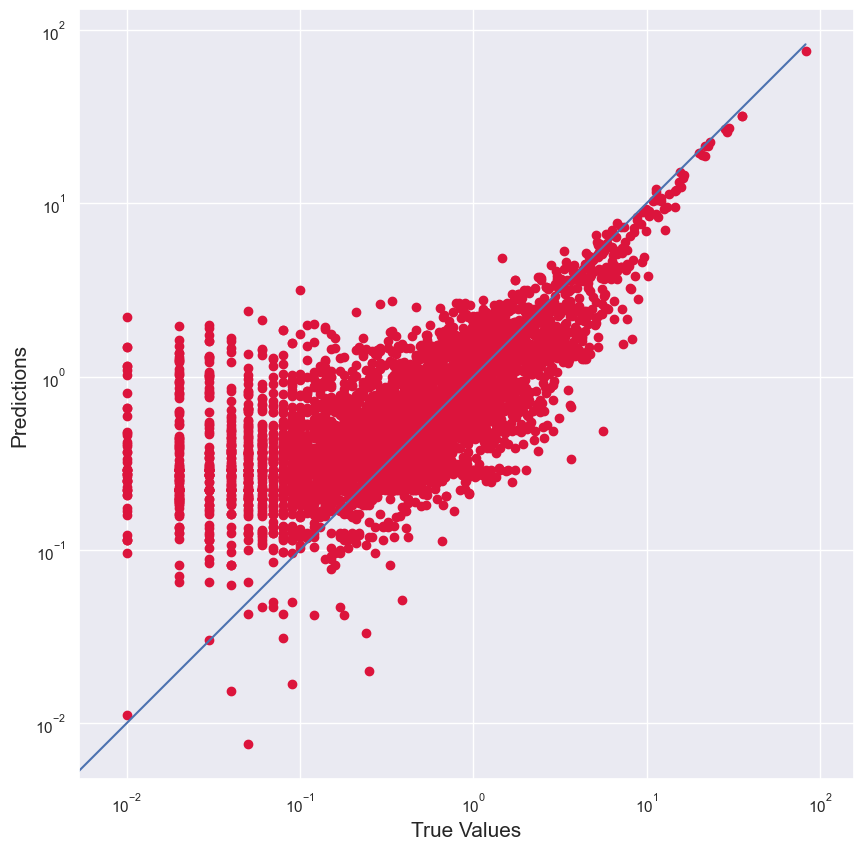

In [156]:
plt.figure(figsize=(10,10))
plt.scatter(y_train, y_train_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_train_pred), max(y_train))
p2 = min(min(y_train_pred), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

....and the test dataset.

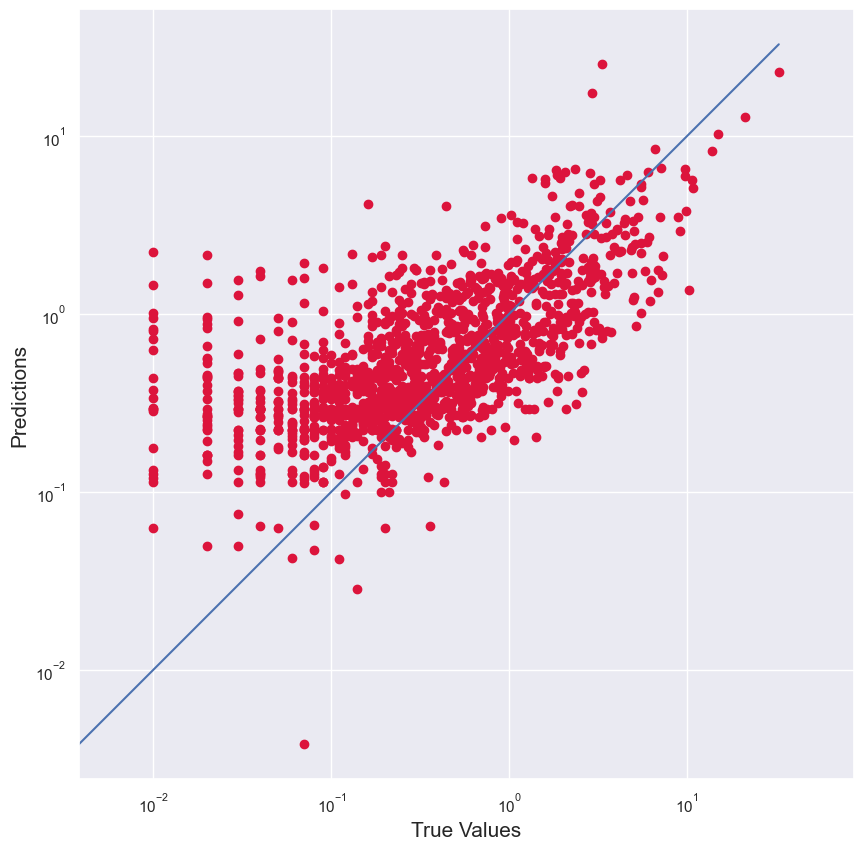

In [157]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## **Conclusion for XG Boost**

Clearly, XGBoost is the best regression model we have to predict Global Sales, boasting the highest train $R^{2}$ value at ~0.9 and the highest test $R^{2}$ value at ~0.45.

## **Overall Conclusion**
-------

Out of all 4 models, XGBoost is the best regression model at predicting Global Sales.

However, all the models have test data accuracy of less than 0.5, which means there might be issues of precision when predicting the exact value of Global Sales given certain variables. This is due to the nature of the dataset, which is a long-tailed boxplot, which means there is a huge positive skew in the boxplot due to popular games selling much, much higher than the mean of all games, causing the regression models to have difficulty in correctly estimating the value of Global Sales.

Ranking of models:
1. XGBoost Regression (~0.45)
2. Ridge Regression (~0.37)
3. Random Forest Regression (~0.32)
4. Linear Regression (~0.31)

Furthermore, we have also seen that User_Count, Critic_Count and Critic_Score are the most important variables when predicting the total global sales of a video game.

-------

Therefore, this gives us the answer to our **first and second** problem statements.
- We are able to predict Global Sales (response) using our predictors, but our models applied are only useful to a small extent due to the long-tailed nature of the dataset. This means that the prediction is not very accurate.
- We can identiy the most important feature in predicting Global Sales, i.e. User_Count, Critic_Count and Critic_Score (in that order).